# RAPIDS & Scanpy Single-Cell RNA-seq Workflow

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of ~70,000 human lung cells from Travaglini et al. 2020 (https://www.biorxiv.org/content/10.1101/742320v2) and label cells using the ACE2 and TMPRSS2 genes. See the README for instructions to download this dataset.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans

import rapids_scanpy_funcs

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [2]:
## SCVi Imports
import scvi
from typing import Tuple
import matplotlib.pyplot as plt

We use the RAPIDS memory manager on the GPU to control how memory is allocated.

In [3]:
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

We recommend saving count matrices in the sparse .h5ad format as it is much faster to load than a dense CSV file. To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [4]:
input_file = "../data/krasnow_hlca_10x.sparse.h5ad"

## Set parameters

In [5]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

In [6]:
start = time.time()

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [7]:
data_load_start = time.time()

In [8]:
%%time
adata = sc.read(input_file)

CPU times: user 152 ms, sys: 267 ms, total: 419 ms
Wall time: 427 ms


We maintain the index of unique genes in our dataset:

In [9]:
%%time
genes = cudf.Series(adata.var_names)
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

CPU times: user 1.66 s, sys: 711 ms, total: 2.37 s
Wall time: 2.4 s


Verify the shape of the resulting sparse matrix:

In [10]:
sparse_gpu_array.shape

(65662, 26485)

And the number of non-zero values in the matrix:

In [11]:
sparse_gpu_array.nnz

126510394

In [12]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 2.8784291744232178


## Preprocessing

In [13]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [14]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)

CPU times: user 450 ms, sys: 300 ms, total: 750 ms
Wall time: 750 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [15]:
%%time
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=1)

CPU times: user 843 ms, sys: 120 ms, total: 963 ms
Wall time: 961 ms


The size of our count matrix is now reduced.

In [16]:
sparse_gpu_array.shape

(65462, 22058)

In [17]:
%%time
adata = anndata.AnnData(sparse_gpu_array.get())
adata.layers["counts"] = adata.X.copy()

CPU times: user 334 ms, sys: 165 ms, total: 499 ms
Wall time: 498 ms


In [18]:
print (sparse_gpu_array)

  (0, 17)	2.0
  (0, 24)	1.0
  (0, 47)	1.0
  (0, 52)	2.0
  (0, 63)	1.0
  (0, 67)	1.0
  (0, 70)	1.0
  (0, 96)	1.0
  (0, 102)	1.0
  (0, 114)	2.0
  (0, 115)	2.0
  (0, 158)	1.0
  (0, 199)	1.0
  (0, 215)	1.0
  (0, 257)	1.0
  (0, 276)	1.0
  (0, 298)	2.0
  (0, 318)	4.0
  (0, 320)	3.0
  (0, 329)	1.0
  (0, 343)	1.0
  (0, 353)	1.0
  (0, 386)	2.0
  (0, 388)	1.0
  (0, 404)	1.0
  :	:
  (65461, 21795)	1.0
  (65461, 21811)	2.0
  (65461, 21813)	2.0
  (65461, 21817)	8.0
  (65461, 21821)	1.0
  (65461, 21832)	1.0
  (65461, 21835)	1.0
  (65461, 21838)	1.0
  (65461, 21841)	1.0
  (65461, 21848)	1.0
  (65461, 21873)	1.0
  (65461, 21874)	2.0
  (65461, 21903)	5.0
  (65461, 21904)	1.0
  (65461, 21912)	4.0
  (65461, 21925)	1.0
  (65461, 21938)	1.0
  (65461, 21958)	1.0
  (65461, 21967)	6.0
  (65461, 21978)	1.0
  (65461, 21979)	1.0
  (65461, 21997)	15.0
  (65461, 22008)	1.0
  (65461, 22013)	1.0
  (65461, 22023)	1.0


### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [19]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.normalize_total(sparse_gpu_array, target_sum=1e4)

CPU times: user 0 ns, sys: 2.08 ms, total: 2.08 ms
Wall time: 1.08 ms


Next, we log transform the count matrix.

In [20]:
%%time
sparse_gpu_array = sparse_gpu_array.log1p()

CPU times: user 92.9 ms, sys: 56.3 ms, total: 149 ms
Wall time: 149 ms


### Select Most Variable Genes

We will now select the most variable genes in the dataset. However, we first save the 'raw' expression values of the ACE2 and TMPRSS2 genes to use for labeling cells afterward. We will also store the expression of an epithelial marker gene (EPCAM).

In [21]:
%%time
tmp_norm = sparse_gpu_array.tocsc()
marker_genes_raw = {
    ("%s_raw" % marker): tmp_norm[:, genes[genes == marker].index[0]].todense().ravel()
    for marker in markers
}

del tmp_norm

CPU times: user 557 ms, sys: 243 ms, total: 799 ms
Wall time: 797 ms


Now, we convert the count matrix to an annData object.

In [23]:
%%time
print (adata)
adata.X = sparse_gpu_array.get()
adata.var_names = genes.to_pandas()
print (adata)

AnnData object with n_obs × n_vars = 65462 × 22058
    layers: 'counts'
AnnData object with n_obs × n_vars = 65462 × 22058
    layers: 'counts'
CPU times: user 155 ms, sys: 109 ms, total: 265 ms
Wall time: 263 ms


Using scanpy, we filter the count matrix to retain only the 5000 most variable genes.

In [24]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.15 s, sys: 15.9 ms, total: 1.17 s
Wall time: 1.19 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of ribosomal genes. Many workflows use the expression of mitochondrial genes (named starting with `MT-`).

In [25]:
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

We now calculate the total counts and the percentage of ribosomal counts for each cell.

In [26]:
%%time
n_counts = adata.X.sum(axis=1)
percent_ribo = (adata.X[:,ribo_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_ribo = cp.array(percent_ribo).ravel()

CPU times: user 984 ms, sys: 39.9 ms, total: 1.02 s
Wall time: 1.02 s


And perform regression:

In [27]:
%%time
sparse_gpu_array = cp.sparse.csc_matrix(adata.X)

CPU times: user 794 ms, sys: 144 ms, total: 938 ms
Wall time: 936 ms


In [28]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array, n_counts, percent_ribo)

CPU times: user 45.4 s, sys: 8.36 s, total: 53.8 s
Wall time: 55.3 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [29]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.scale(sparse_gpu_array, max_value=10)

CPU times: user 261 ms, sys: 189 ms, total: 450 ms
Wall time: 448 ms


In [30]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 510.3873839378357


## SCVi training function

In [31]:
def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 5,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
):
    """Train and return a scVI model and sample a latent space

    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    scvi.data.setup_anndata(adata, layer="counts")
    # Train a model
    vae = scvi.model.SCVI(
        adata,
        n_latent=n_latent,
        use_cuda=use_cuda
    )
    vae.train(n_epochs=n_epochs, train_size=0.9)

    latent = vae.get_latent_representation()

    return latent

## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [35]:
#%%time
genes = adata.var_names
adata_layers = adata.layers
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes
adata.layers = adata_layers

for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()
    
print (adata)

AnnData object with n_obs × n_vars = 65462 × 5000
    obs: 'ACE2_raw', 'TMPRSS2_raw', 'EPCAM_raw'
    layers: 'counts'


## SCVI LATENTS

In [37]:
%%time
n_epochs = 5

# use_cuda to use GPU
use_cuda = True

scvi_latent = compute_scvi_latent(
    adata, n_epochs=n_epochs, n_latent=10, use_cuda=use_cuda
)
adata.obsm["X_scvi"] = scvi_latent
    

INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  130 s. / 5 epochs                                                  
CPU times: user 12min 43s, sys: 10min 58s, total: 23min 42s
Wall time: 2min 11s
Compiler : 315 ms


In [38]:
print (scvi_latent)

[[ 3.810614    0.8385543   0.6335852  ... -0.10288313  1.1683028
   1.0108287 ]
 [ 3.446305    1.3727486   0.5923714  ... -0.41139024  1.6604854
   1.0453393 ]
 [ 3.070623    0.7699594   0.02425381 ... -0.6093116   1.5321677
   1.3001492 ]
 ...
 [ 3.0282788  -2.7549238  -2.0657933  ...  0.9560659  -0.09619156
   1.9266145 ]
 [ 3.5642934  -2.9254177  -2.0380166  ...  0.2900154  -0.26767612
   2.7388995 ]
 [ 3.2390897  -5.23933    -1.7258375  ...  1.2272913  -0.10919355
   0.37393135]]


In [55]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
print (trainer.history)
%matplotlib inline
print (len(elbo_train_set))
x = np.linspace(0, n_epochs, (len(elbo_train_set)))
plt.plot(x, elbo_train_set, label="train")
plt.plot(x, elbo_test_set, label="test")
plt.ylim(4000, 90000)
plt.legend()

NameError: name 'trainer' is not defined

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [39]:
#%%time
#adata.obsm["X_pca"] = PCA(n_components=n_components, output_type="numpy").fit_transform(adata.X)

### T-SNE + k-Means

We next use t-SNE on the top 20 principal components to visualize the cells in two dimensions.

In [40]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_scvi"][:,:10])

CPU times: user 1.1 s, sys: 937 ms, total: 2.04 s
Wall time: 2.08 s


We cluster the cells using k-means on the principal components. For example purposes, we set k=35.

In [41]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_scvi'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 213 ms, sys: 33.2 ms, total: 246 ms
Wall time: 265 ms


We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

... storing 'kmeans' as categorical


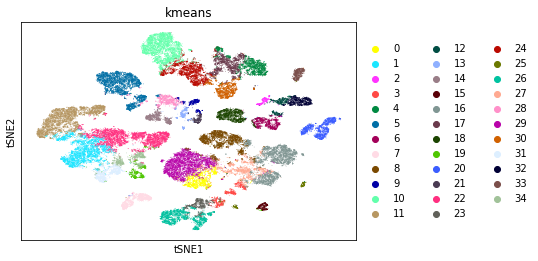

CPU times: user 1.2 s, sys: 19.6 ms, total: 1.22 s
Wall time: 1.26 s


In [42]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

Separately, we label the cells using the 'raw' expression of the EPCAM, ACE2 and TMPRSS2 marker genes.

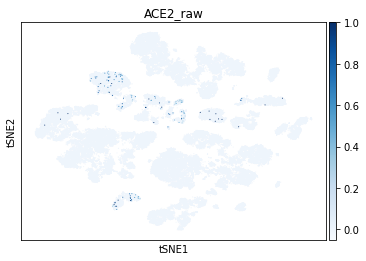

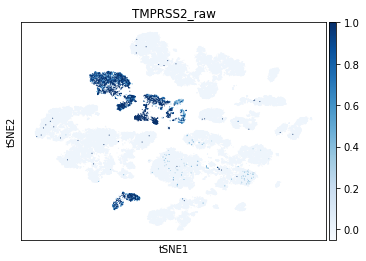

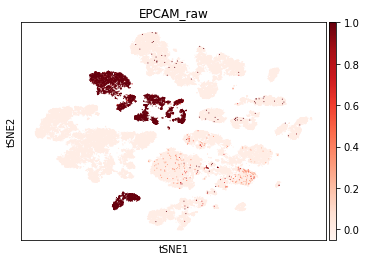

CPU times: user 965 ms, sys: 12.7 ms, total: 977 ms
Wall time: 973 ms


In [43]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [44]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

         Falling back to preprocessing with `sc.pp.pca` and default params.
CPU times: user 1min 2s, sys: 1.77 s, total: 1min 4s
Wall time: 16.1 s


The UMAP function from Rapids is also integrated into Scanpy.

In [45]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 438 ms, sys: 347 ms, total: 785 ms
Wall time: 842 ms


Next, we use the Louvain algorithm for graph-based clustering, once again using the `rapids` option in Scanpy.

In [46]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 189 ms, sys: 72.6 ms, total: 261 ms
Wall time: 288 ms


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

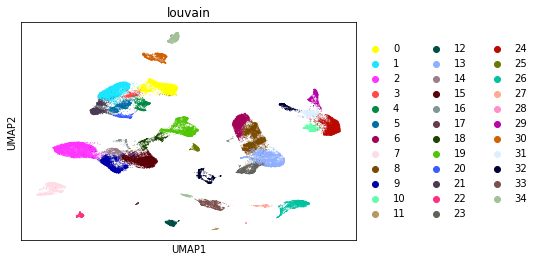

CPU times: user 1.07 s, sys: 21.9 ms, total: 1.1 s
Wall time: 1.09 s


In [47]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also use the Leiden clustering method in RAPIDS. This method has not been integrated into Scanpy and needs to be called separately.

In [48]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 212 ms, sys: 69.5 ms, total: 281 ms
Wall time: 292 ms


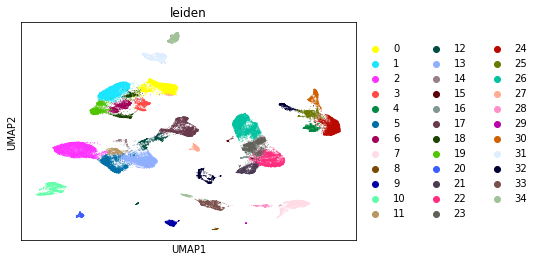

CPU times: user 1.18 s, sys: 21.8 ms, total: 1.2 s
Wall time: 1.2 s


In [49]:
%%time
sc.pl.umap(adata, color=["leiden"])

We can also view cells using UMAP and labeling by raw EPCAM, ACE2 and TMPRSS2 expression.

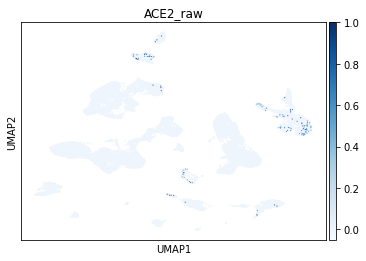

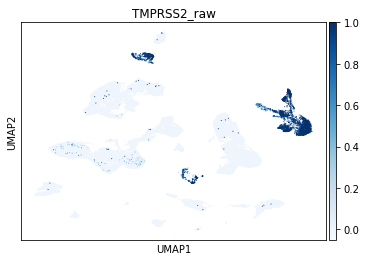

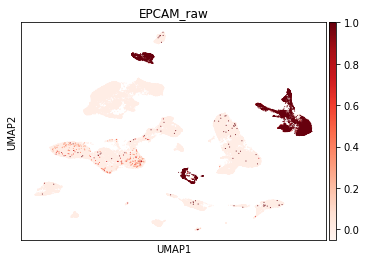

CPU times: user 914 ms, sys: 11.4 ms, total: 925 ms
Wall time: 918 ms


In [50]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

## Differential expression analysis

Once we have done clustering, we can compute a ranking for the highly differential genes in each cluster. Here we use the Louvain clusters as labels.

In [51]:
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
genes = cudf.Series(genes)

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [52]:
%%time
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    sparse_gpu_array, 
    cluster_labels, 
    genes, 
    n_genes=ranking_n_top_genes, groups='all', reference='rest')

Ranking took (GPU): 2.7853498458862305
Preparing output np.rec.fromarrays took (CPU): 0.0007975101470947266
Note: This operation will be accelerated in a future version
CPU times: user 1.52 s, sys: 1.24 s, total: 2.76 s
Wall time: 2.83 s


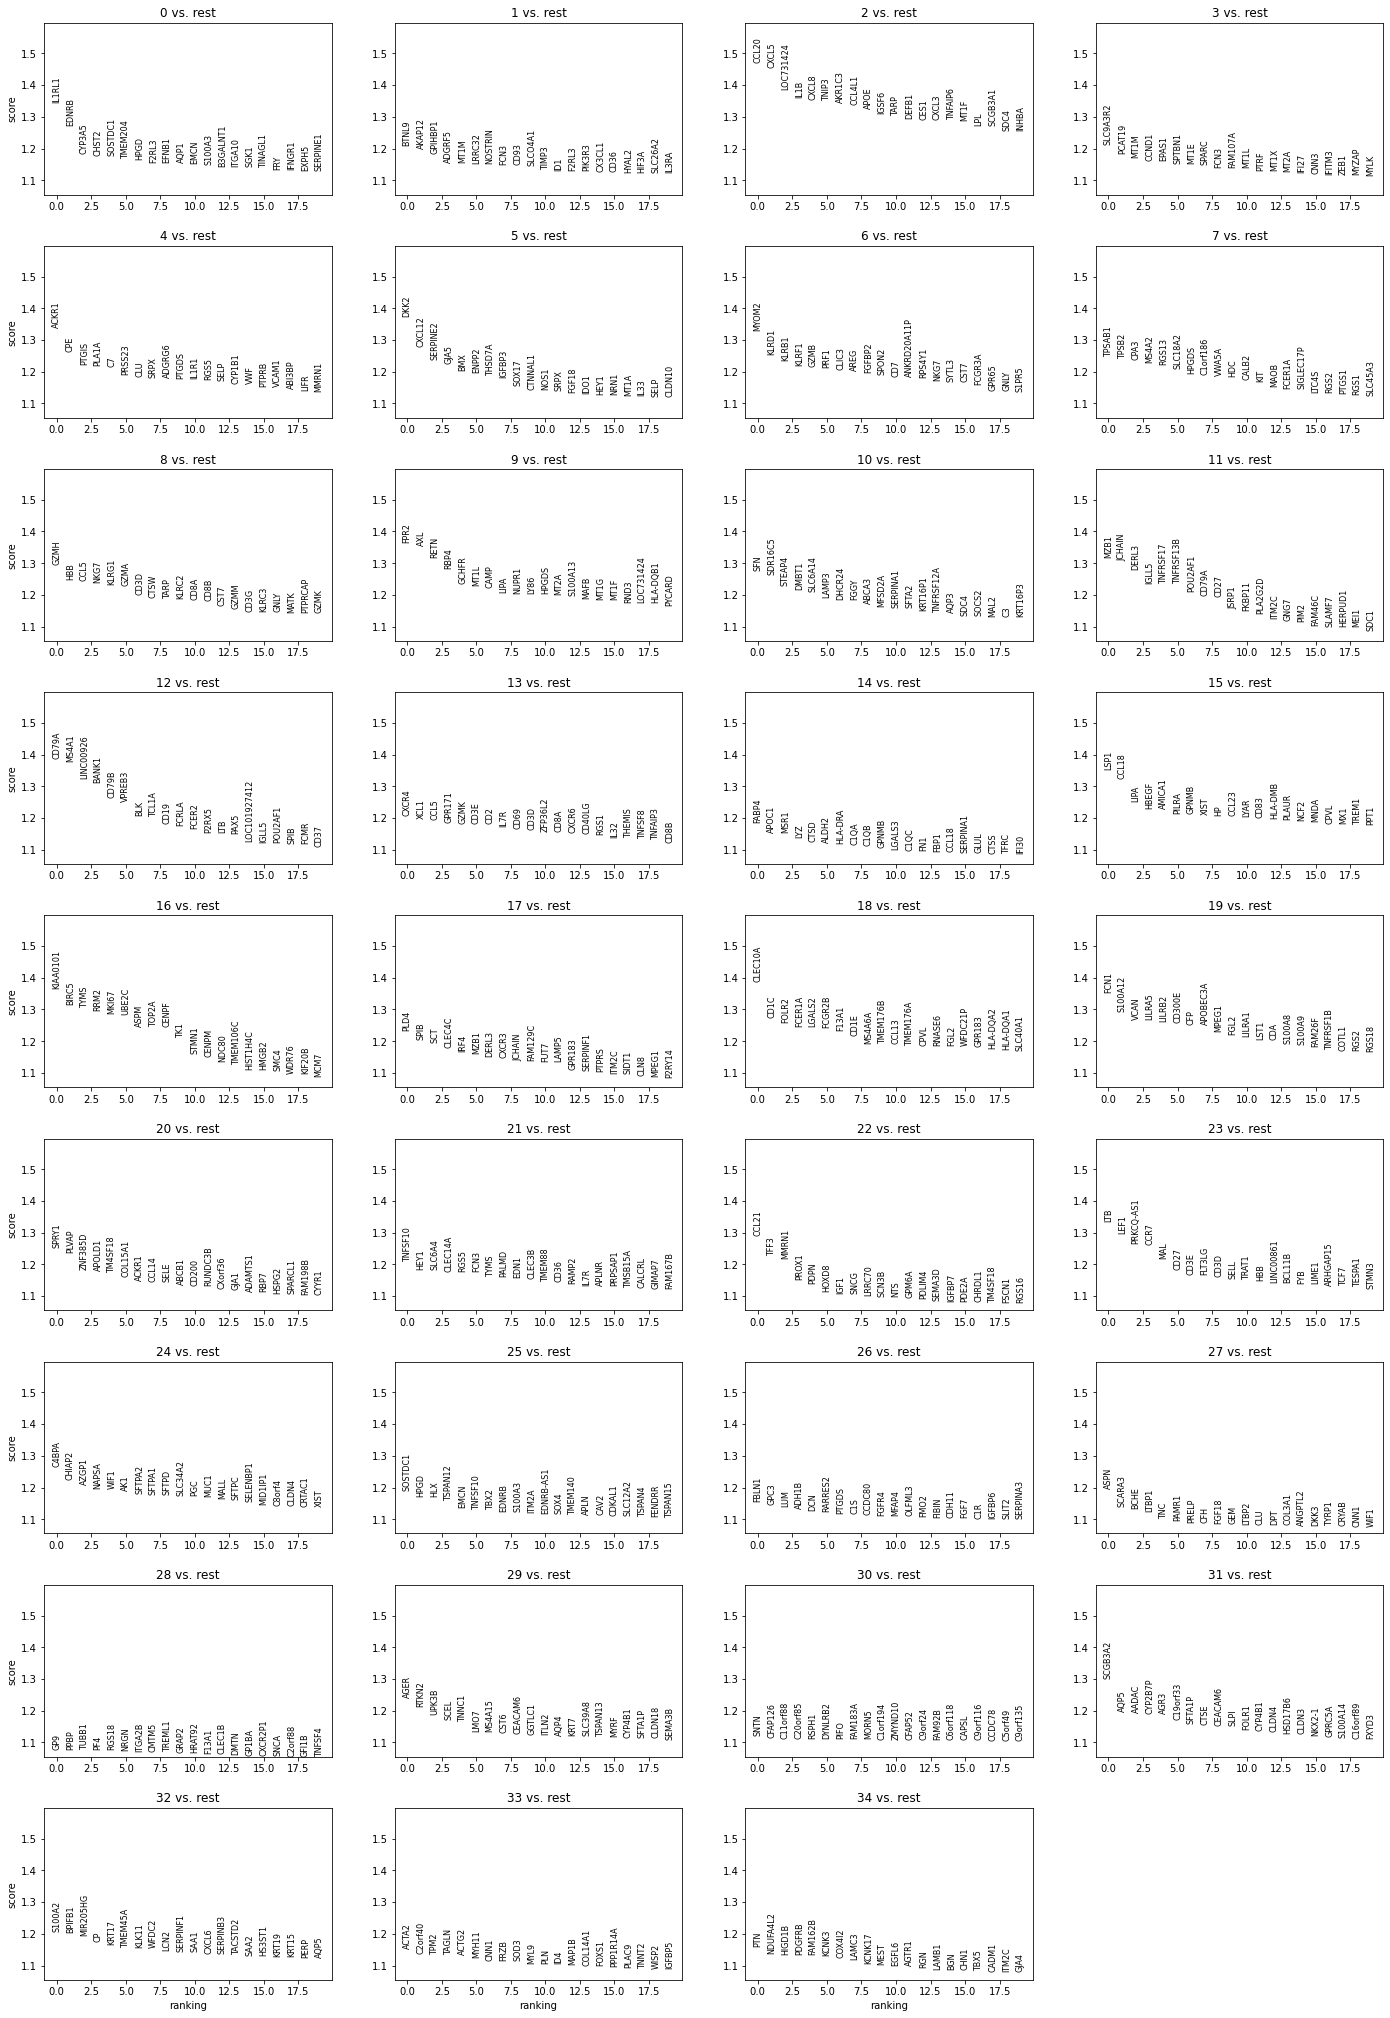

CPU times: user 5.58 s, sys: 346 ms, total: 5.92 s
Wall time: 5.92 s


In [53]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [54]:
reanalysis_start = time.time()

In [57]:
%%time
print (adata)
epcam_cells = adata.obs["EPCAM_raw"] > 0.0
adata = adata[epcam_cells,:]
adata.shape
print (adata)

View of AnnData object with n_obs × n_vars = 7958 × 5000
    obs: 'ACE2_raw', 'TMPRSS2_raw', 'EPCAM_raw', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'kmeans', 'louvain', 'leiden'
    uns: '_scvi', 'kmeans_colors', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_scvi', 'X_tsne', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'
View of AnnData object with n_obs × n_vars = 7958 × 5000
    obs: 'ACE2_raw', 'TMPRSS2_raw', 'EPCAM_raw', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'kmeans', 'louvain', 'leiden'
    uns: '_scvi', 'kmeans_colors', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_scvi', 'X_tsne', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'
CPU times: user 8.7 ms, sys: 681 µs, total: 9.39 ms
Wall time: 8.4 ms


We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

In [59]:
%%time
adata=adata.copy()
scvi_latent = compute_scvi_latent(
    adata, n_epochs=n_epochs, n_latent=10, use_cuda=use_cuda
)
adata.obsm["X_scvi"] = scvi_latent
#adata.obsm["X_pca"] = PCA(n_components=n_components, output_type="numpy").fit_transform(adata.X)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  15 s. / 5 epochs                                                   
CPU times: user 1min 38s, sys: 1min 17s, total: 2min 56s
Wall time: 17.6 s


And plot the results:

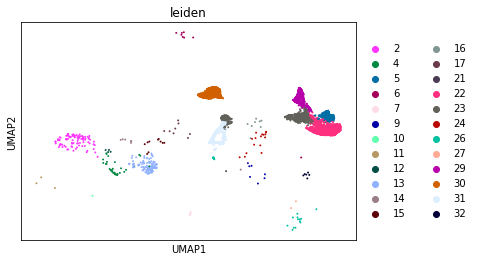

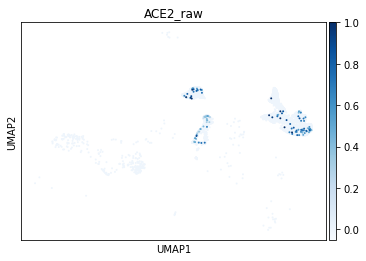

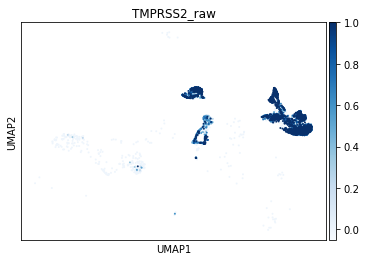

CPU times: user 932 ms, sys: 27.4 ms, total: 960 ms
Wall time: 963 ms


In [51]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [52]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 11.94851541519165


In [53]:
print("Full time: %s" % (time.time() - start))

Full time: 807.8285524845123
